In [1]:
import h5py
import librosa
import numpy as np

file = h5py.File('E:/dataset_6ms.h5', 'r')
#label_dict = {"['n']": 0, "['c']": 1, "['h']": 2, "['s']": 3,
 #             "['a']": 4, "['f']": 5, "['d']": 6, "['su']": 7}

gender_labels = file['gender'][...].squeeze().astype(str)
print('done!')

# female_indexes =  np.where(gender_labels == 'female')
indexes =  np.where(gender_labels == 'female')
print('done!')
y = file['label'][indexes]
print('done!')
X = file['mfcc'][indexes]
print('done!')

# print('done!')
# y = file['label'][relevant_indexes]
# print('done!')
# X = file['mfcc'][relevant_indexes]
# print('done!')

X.shape, y.shape

done!
done!
done!
done!


((24133, 13, 50), (24133, 1))

In [2]:
# extract delta and double delta features using librosa
X_deltas = np.zeros((X.shape[0], X.shape[1]*3, X.shape[2]))
print(X_deltas.shape)
for i in range(X.shape[0]):
    X_delta = librosa.feature.delta(X[i])
    X_delta2 = librosa.feature.delta(X[i], order=2)
    # np.vstack all the X, X_delta and X_delta2 
    new_features = np.vstack([X[i], X_delta, X_delta2])
    X_deltas[i] = new_features
    # print(X_deltas[i].shape)

(24133, 39, 50)


In [3]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_deltas, y, test_size=0.33, random_state=32)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((16169, 39, 50), (7964, 39, 50), (16169, 1), (7964, 1))

In [2]:

import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential 
from keras.layers import Dense, BatchNormalization, GlobalAveragePooling2D, GlobalMaxPooling2D, Add
from keras.layers import Flatten, Dropout, LeakyReLU, Permute, Activation
from keras.layers import Conv2D, MaxPooling2D, Reshape, AveragePooling2D
from keras.layers import Conv1D, Layer
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.optimizers import adam_v2
import tensorflow as tf
# import rms prop from keras

class Residual(Layer):
    def __init__(self, channels_in,kernel,**kwargs):
        super(Residual, self).__init__(**kwargs)
        self.channels_in = channels_in
        self.kernel = kernel
    @tf.function
    def call(self, x):
        # the residual block using Keras functional API
        first_layer =   Activation("linear", trainable=False)(x)
        x =             Conv2D( self.channels_in,
                                self.kernel,
                                padding="same")(first_layer)
        x =             LeakyReLU(alpha=0.08)(x)
        x =             Conv2D( self.channels_in,
                                self.kernel,
                                padding="same")(x)
        residual =      Add()([x, first_layer])
        x =             LeakyReLU(alpha=0.08)(residual)
        return x
    @tf.function
    def compute_output_shape(self, input_shape):
        return input_shape



es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)
opt = adam_v2.Adam(learning_rate=0.0007)
# model.compile(loss='categorical_crossentropy', optimizer=opt)

feature_shape = X_train[0].shape
print(feature_shape)
model = Sequential()
model.add(Reshape(target_shape=(
    feature_shape[0], feature_shape[1], 1), input_shape=(feature_shape[0], feature_shape[1])))

model.add(Permute((2, 1, 3)))
model.add(Dense(39, activation='relu'))
model.add(Permute((2,1,3)) )


# 0 conv layer
model.add(Conv2D(48, (1, 1), strides=(1, 1)))
model.add(LeakyReLU(alpha=0.005))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3, 3)))
model.add(LeakyReLU())
model.add(MaxPooling2D(pool_size=(2, 3)))
model.add(Dropout(0.2))

# 1st conv layer
model.add(Conv2D(128, (3, 3),))
model.add(LeakyReLU())
model.add(MaxPooling2D(pool_size=(2, 3)))
model.add(Dropout(0.2))

# 2nd conv layer
model.add(Conv2D(256, (3,3)))
model.add(LeakyReLU())
model.add(BatchNormalization())
model.add(Dropout(0.2))

# flatten the output and add a dense layer
model.add(Flatten())

# model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.4))

model.add(Dense(6, activation='softmax'))
model.summary()
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=opt, metrics=['sparse_categorical_accuracy'])


NameError: name 'X_train' is not defined

In [1]:
cnnhistory=model.fit(X_train, y_train, batch_size=800, epochs=200,validation_data=(X_test, y_test), shuffle=True, callbacks=[es], verbose=1)


NameError: name 'model' is not defined

In [19]:
# save the model history
# cnnhistory.model.save('cnn_66.h5')

Model Accuracy Metrics: 


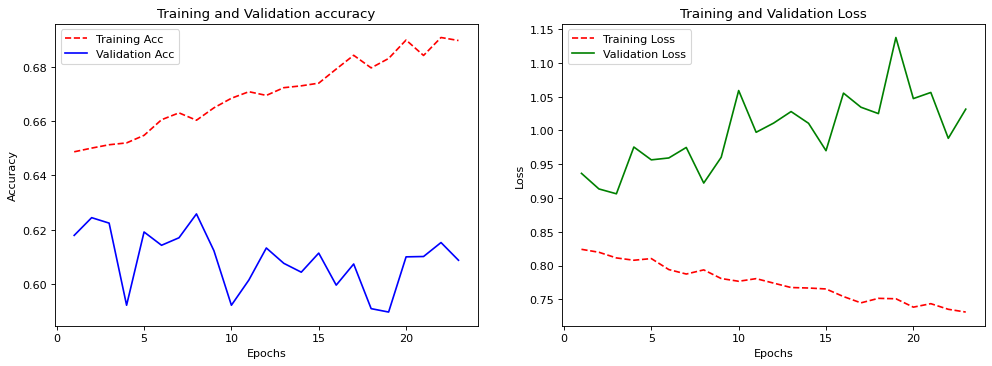

In [46]:
# my_model.save('my_model_984.h5')
acc = cnnhistory.history['sparse_categorical_accuracy']
val_acc = cnnhistory.history['val_sparse_categorical_accuracy']
epochs = range(1, len(acc) + 1)
loss = cnnhistory.history['loss']
val_loss = cnnhistory.history['val_loss']

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,5), dpi=80)

ax[0].plot(epochs, acc,'--r', label='Training Acc')
ax[0].plot(epochs, val_acc, '-b', label='Validation Acc')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend()
ax[0].set_title('Training and Validation accuracy')

ax[1].plot(epochs, loss,'--r' ,label='Training Loss')
ax[1].plot(epochs, val_loss, '-g',label='Validation Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend()
ax[1].set_title('Training and Validation Loss')

print("Model Accuracy Metrics: ")
plt.show()
plt.close()

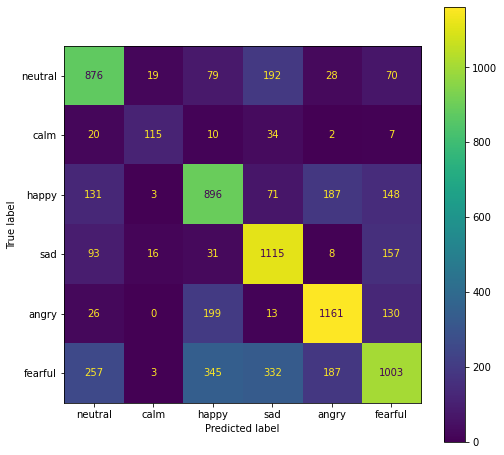

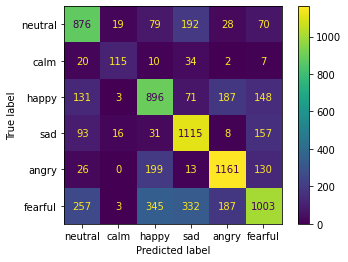

In [33]:
from sklearn.metrics import ConfusionMatrixDisplay
labels = ['neutral','calm','happy','sad','angry','fearful']
## Display the visualization of the Confusion Matrix.
y_pred = model.predict(X_test).argmax(axis=1)
# print(y_pred.argmax(axis=1))
fig, ax = plt.subplots(figsize=(8,8))

ConfusionMatrixDisplay.from_predictions(y_pred, y_test, display_labels=labels).plot(ax=ax)
plt.show()
plt.close()

In [ ]:
from tensorflow import keras
old = keras.models.load_model('cnn_63.h5')
old.summary()